In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import netCDF4
from scipy import stats
import statsmodels.api as sm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.path.append('/Users/gbromley/code/python_utilities/')
from python_data_functions import extract_months
from python_met_functions import sat_vap_pres
from python_data_functions import mk_test
import metpy.calc as mcalc
from metpy.units import units
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText




In [2]:
data_dir = '/Users/gbromley/data/CRU/'
output_dir='/Users/gbromley/code/NGP_Climate/'
temp_file = 'tmp/cru_ts3.24.1901.2015.tmp.dat.nc'
#vap_file = 'vap/cru_ts3.24.1901.2015.vap.dat.nc'
#nc_vap = xr.open_dataset(data_dir+vap_file)
nc_temp = xr.open_dataset(data_dir+temp_file)


In [3]:
t2m = nc_temp['tmp']


In [4]:
t_season='AMJ'
t_months=[4,5,6]
start_year = '1970-01-01'
end_year = '2015-12-01'
ext_e = -92
ext_w = -120
ext_n = 55
ext_s = 38
t2m = t2m.sel(lat=slice(ext_s,ext_n),lon=slice(ext_w,ext_e))
#ggw_lat,ggw_lon = 48.18, -106.635

In [6]:
test = t2m['lat']

In [5]:
#extract the time period we are interested in
t2m_slice=t2m.sel(time=slice(start_year,end_year))
#grab the months interested in
t2m_months = t2m_slice.sel(time=extract_months(t2m_slice['time.month'],t_months[0],t_months[-1]))
#create month averages
t2m_months_avg = t2m_months.groupby('time.year').mean(dim='time')

#extract the 30 yr climate normal times
t2m_clim_30= t2m.sel(time=slice('1980-01-01','2011-01-01'))
#grab the months
t2m_clim_months_30 = t2m_clim_30.sel(time=extract_months(t2m_clim_30['time.month'],t_months[0],t_months[-1]))
#create averages over months for climate normal
t2m_clim_months_avg = t2m_clim_months_30.mean(dim='time')

In [17]:
test = t2m_clim_months_30.groupby('time.month').mean(dim='time')

In [9]:
test


<xarray.DataArray 'tmp' (month: 3, lat: 34, lon: 56)>
array([[[  3.748387,   4.087097, ...,  13.696774,  13.745161],
        [  4.587097,   5.509677, ...,  12.951613,  12.96129 ],
        ..., 
        [  0.522581,   1.922581, ...,  -1.590323,  -1.696774],
        [  3.419355,   3.709677, ...,  -2.303226,  -2.619355]],

       [[  8.377419,   8.854839, ...,  18.583871,  18.477419],
        [  9.396774,  10.551613, ...,  18.083871,  17.980645],
        ..., 
        [  5.13871 ,   6.496774, ...,   6.493548,   6.319355],
        [  8.322581,   8.783871, ...,   5.770968,   5.5     ]],

       [[ 12.570968,  13.36129 , ...,  23.303226,  23.229032],
        [ 13.825806,  15.106452, ...,  22.874194,  22.693548],
        ..., 
        [  8.867742,  10.254839, ...,  13.219355,  13.148387],
        [ 12.096774,  12.483871, ...,  12.751613,  12.574194]]])
Coordinates:
  * lon      (lon) float64 -119.8 -119.2 -118.8 -118.2 -117.8 -117.2 -116.8 ...
  * lat      (lat) float64 38.25 38.75 39.25 39.7

In [10]:
#create 2d structure to hold slope
spatial_trend = t2m.isel(time=1).copy(deep=True)
spatial_trend.name = 't2m_trend'
spatial_trend.attrs['units'] = 'C per Decade'
spatial_trend.attrs['long_name'] = '2 meter temperature trend'

#create 2d structure to hold pvalues
pvalues= t2m.isel(time=1).copy(deep=True)
pvalues.name = 't2m_trend_pvalues'
pvalues.attrs['units'] = 'pvalues'
pvalues.attrs['long_name'] = '2 meter temperature trend pvalues'

In [73]:
#calculate slope and pvalue for each grid point
#replace with a map() call?
for i in np.arange(0,len(t2m['lat'])):
    for j in np.arange(0,len(t2m['lon'])):
        series = t2m_months[:,i,j]
        anom = series.groupby('time.month')-test[:,i,j]
        model = sm.OLS(np.asarray(anom.values),np.arange(0,len(anom)))
        results = model.fit()
        slope = results.params[0]
        t_value = ((slope*3 - 0.02)/results.bse)
        p_value = (stats.t.sf(t_value, results.df_resid))
       # p_value = stats.t.sf(results.tvalues[0], results.df_resid)
        spatial_trend[i,j]=slope*30
        pvalues[i,j]= p_value
        #print(i)

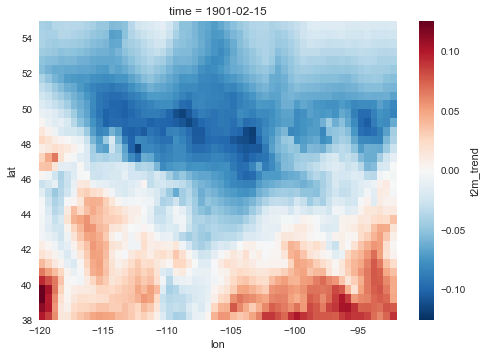

In [74]:
spatial_trend.plot()

In [85]:
corr_vals = np.arange(0,len(anom))
#corr_vals = sm.add_constant(corr_vals)
series = t2m_months[:,28,45]
anom = series.groupby('time.month')-test[:,28,45]
anom = anom.to_dataframe()
model = sm.OLS(np.asarray(anom['tmp'].values),corr_vals)
results = model.fit()
slope = results.params[0]
t_value = ((slope*3-0.02)/results.bse[0])
p_value = (stats.t.sf(t_value, results.df_resid))
#p_value_2 = stats.t.sf(results.tvalues[0],results.df_resid)
#stats.ttest_1samp()
#spatial_trend[i,j]=slope*10
#pvalues[i,j]=p_value 
# - (0.2/10)

In [86]:
slope

-0.0015908332410415715

In [18]:
test = test.mean(dim=['lat','lon'])

In [19]:
april = t2m_months.mean(dim=['lat','lon']).sel(time=extract_months(t2m_months['time.month'],t_months[0],t_months[0])) - test[0]
may = t2m_months.mean(dim=['lat','lon']).sel(time=extract_months(t2m_months['time.month'],t_months[1],t_months[1])) - test[1]
june = t2m_months.mean(dim=['lat','lon']).sel(time=extract_months(t2m_months['time.month'],t_months[2],t_months[2])) - test[2]
amj = t2m_months.mean(dim=['lat','lon']).groupby('time.month')-test[:]
amj_year = amj.groupby('time.year').mean()

corr_april = np.arange(0,len(april.time))
corr_april = sm.add_constant(corr_april)

corr_may = np.arange(0,len(may.time))
corr_may = sm.add_constant(corr_may)

corr_june = np.arange(0,len(june.time))
corr_june = sm.add_constant(corr_june)

corr_amj = np.arange(0,len(amj.time))
corr_amj = sm.add_constant(corr_amj)

corr_amj_year = np.arange(0,len(amj_year.year))
corr_amj_year = sm.add_constant(corr_amj_year)

model_april = sm.OLS(np.asarray(april.values),corr_april).fit()
model_may = sm.OLS(np.asarray(may.values),corr_may).fit()
model_june = sm.OLS(np.asarray(june.values),corr_june).fit()


model_amj = sm.OLS(np.asarray(amj.values),corr_amj).fit()


model_amj_year = sm.OLS(np.asarray(amj_year.values),corr_amj_year).fit()

In [96]:
corr_april

array([[  1.,   0.],
       [  1.,   1.],
       [  1.,   2.],
       [  1.,   3.],
       [  1.,   4.],
       [  1.,   5.],
       [  1.,   6.],
       [  1.,   7.],
       [  1.,   8.],
       [  1.,   9.],
       [  1.,  10.],
       [  1.,  11.],
       [  1.,  12.],
       [  1.,  13.],
       [  1.,  14.],
       [  1.,  15.],
       [  1.,  16.],
       [  1.,  17.],
       [  1.,  18.],
       [  1.,  19.],
       [  1.,  20.],
       [  1.,  21.],
       [  1.,  22.],
       [  1.,  23.],
       [  1.,  24.],
       [  1.,  25.],
       [  1.,  26.],
       [  1.,  27.],
       [  1.,  28.],
       [  1.,  29.],
       [  1.,  30.],
       [  1.,  31.],
       [  1.,  32.],
       [  1.,  33.],
       [  1.,  34.],
       [  1.,  35.],
       [  1.,  36.],
       [  1.,  37.],
       [  1.,  38.],
       [  1.,  39.],
       [  1.,  40.],
       [  1.,  41.],
       [  1.,  42.],
       [  1.,  43.],
       [  1.,  44.],
       [  1.,  45.]])

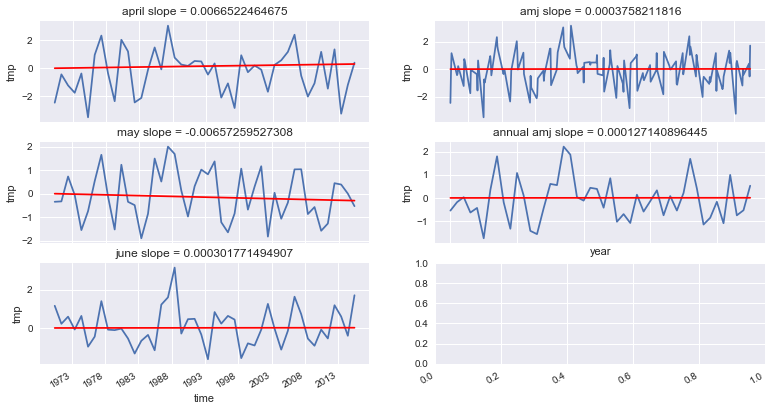

In [20]:
f, axes = plt.subplots(3,2)
f.set_size_inches(13,7)
f.set_dpi=1200.0


april.plot(ax=axes[0,0])
axes[0,0].plot(april.time,model_april.params[1]*np.arange(0,len(april.values)),color='red')
axes[0,0].set_title('april slope = '+str(model_april.params[1]))

may.plot(ax=axes[1,0])
axes[1,0].plot(may.time,model_may.params[1]*np.arange(0,len(may.values)),color='red')
axes[1,0].set_title('may slope = '+str(model_may.params[1]))

june.plot(ax=axes[2,0])
axes[2,0].plot(june.time,model_june.params[1]*np.arange(0,len(june.values)),color='red')
axes[2,0].set_title('june slope = '+str(model_june.params[1]))

amj.plot(ax=axes[0,1])
axes[0,1].plot(amj.time,model_amj.params[1]*np.arange(0,len(amj.values)),color='red')
axes[0,1].set_title('amj slope = '+str(model_amj.params[1]*3))

amj_year.plot(ax=axes[1,1])
axes[1,1].plot(amj_year.year,model_amj_year.params[1]*np.arange(0,len(amj_year.values)),color='red')
axes[1,1].set_title('annual amj slope = '+str(model_amj_year.params[1]))

In [68]:
print(model_amj_year.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.3400
Date:                Sat, 09 Dec 2017   Prob (F-statistic):              0.563
Time:                        13:24:16   Log-Likelihood:                -83.354
No. Observations:                  46   AIC:                             168.7
Df Residuals:                      45   BIC:                             170.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0049      0.008     -0.583      0.5

In [69]:
t_value = ((model_amj_year.params[0]-0.02)/model_amj_year.bse)
p_value = 1-(stats.t.sf(t_value, model_amj_year.df_resid))

In [70]:
p_value

array([ 0.00252244])

In [71]:
model_amj_year.bse

array([ 0.00845413])

In [72]:
model_amj_year.params[0]

-0.0049293514651158367

In [ ]:
#spatial_trend.to_dataset().to_netcdf(data_dir+'CRU_temp_tobias'+t_season+'_'+'1970'+'.nc')

In [75]:
pvalues.to_dataset().to_netcdf(t_season+'monthly_1970_pvalues.nc')

In [ ]:
anom_series = t2m_months_avg - t2m_clim_months_avg

In [ ]:
test_series = anom_series.sel(lat=48.75)
test_series = test_series.sel(lon=-106.75)
anom_series = test_series
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0,len(anom_series)),anom_series.values)
line = slope*np.arange(0,len(anom_series.values))+intercept
anom_series = anom_series.to_pandas()

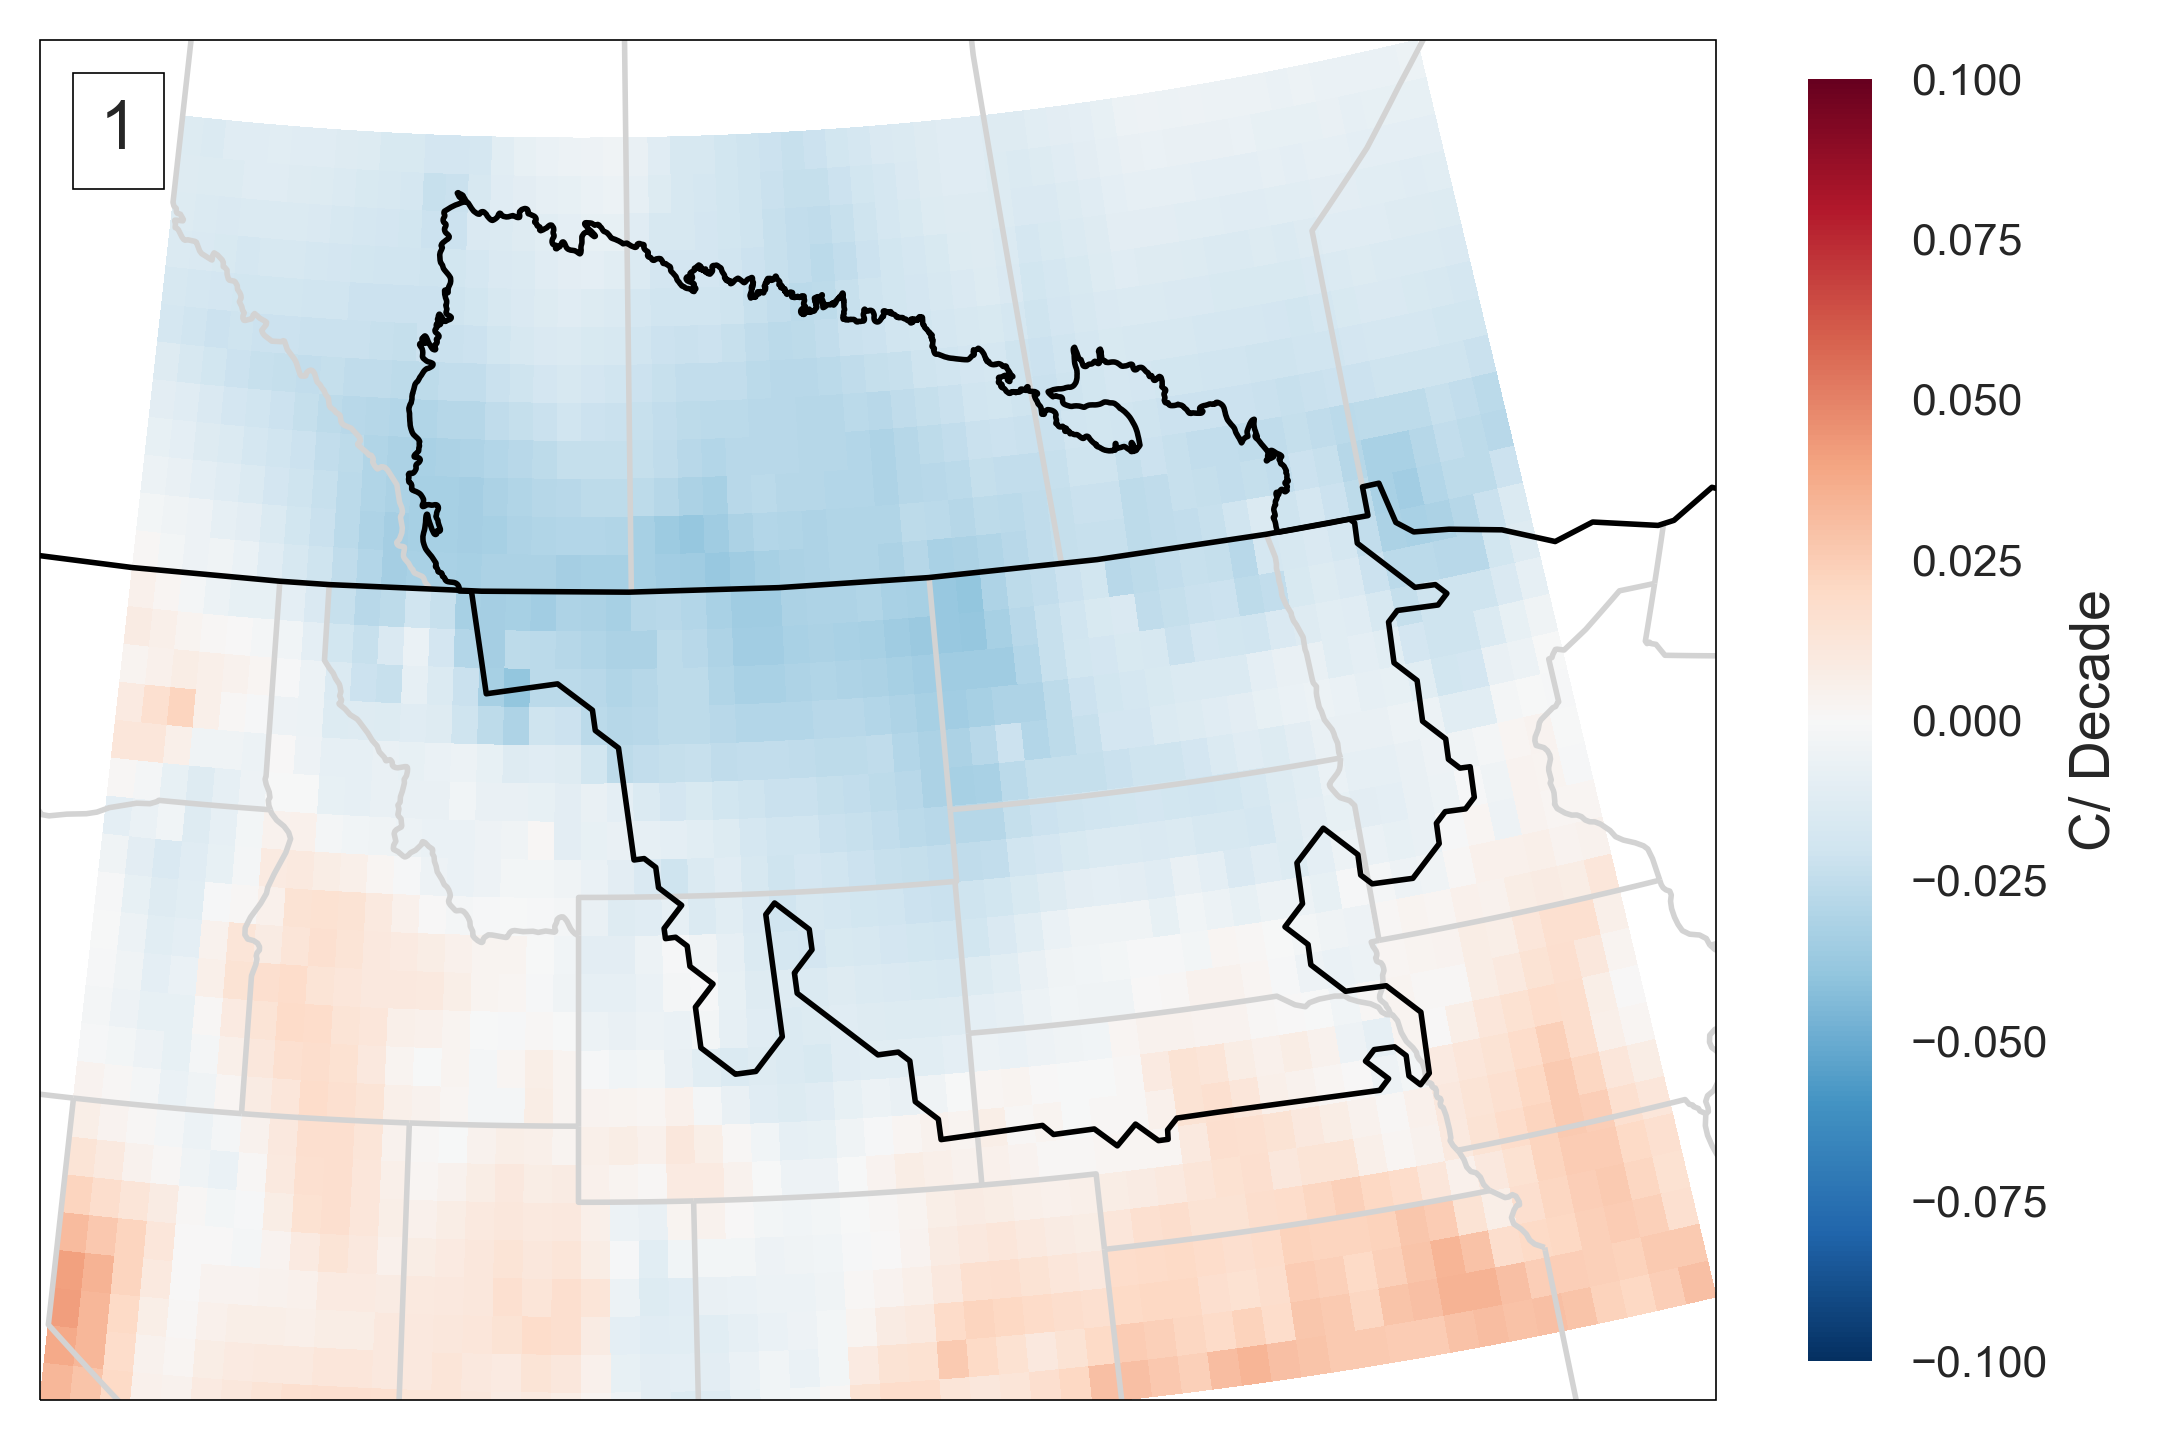

'\nfig2 = plt.figure(2,figsize=(13,7), dpi=1200.0, edgecolor=\'black\')\nax2 = plt.subplot(211, facecolor=\'white\')\n#plt.rc(\'grid\', linestyle="-", color=\'gray\')\n#plt.grid(True)\nanom_series.plot(color=\'blue\')\nanom_series.rolling(window=5).mean().plot( color=\'red\')\nax2.plot(anom_series.index.values,line, color=\'black\')\nbase = np.zeros(len(anom_series.values))\nplt.plot(anom_series.index.values,base,color=\'black\')\n#ax2.set_title(\'Temp at GGW\'+start_year[0:4]+\'-\'+end_year[0:4]+\' \'+t_season)\nax2.set_xlabel(\'Year\')\nax2.set_ylabel(\'Specific Humidity Anomaly [g $\\mathregular{kg^{-1}}$]\')\n#plt.text(0.1, 0.9,\'b\', ha=\'center\', va=\'center\', backgroundcolor=\'lightgray\')\nanchored_text = AnchoredText("b", loc=2)\nax2.add_artist(anchored_text)\nfig2.savefig(\'CRU_sp_hum_moisture_paper\'+start_year[0:4]+\'-\'+end_year[0:4]+\' \'+t_season+\' TS.png\', bbox_inches=\'tight\')\nplt.show()\n'

In [12]:
fig = plt.figure(1,figsize=(13,7), dpi=400.0)
projection = ccrs.AlbersEqualArea(central_longitude=-111.0,central_latitude=46.0,false_easting=0.0, false_northing=0.0, standard_parallels=(40.0, 50.0), globe=None)
ax1 = plt.subplot(1,2,1, projection = projection)
#ax1 = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-111.0,central_latitude=46.0,false_easting=0.0, false_northing=0.0, standard_parallels=(40.0, 50.0), globe=None))
ax1.set_global()
test = spatial_trend.plot.pcolormesh(axes = ax1, transform=ccrs.PlateCarree(),vmin=-0.1, vmax=0.1, cmap='RdBu_r',add_colorbar = False)
#ax = plt.axes(projection=ccrs.LambertConformal())

ax1.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces, edgecolor='lightgray')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS)
shape_feature = ShapelyFeature(Reader('/Users/gbromley/Dropbox/Montana_Climate_Project/Study_Area/Study_Area_08_01_17.shp').geometries(),crs=ccrs.PlateCarree(), facecolor='none',edgecolor='black')
ax1.add_feature(shape_feature)
#plt.plot(ggw_lon, ggw_lat, axes = ax1, marker='o', markersize = 8, color='black', transform=ccrs.PlateCarree())
#plt.plot(ftp_lon, ftp_lat, axes = ax1, marker='o', markersize = 8, color='black', transform=ccrs.PlateCarree())
#plt.text(ftp_lon+0.5, ftp_lat, 'US-FPe', axes=ax1, color='black', size=8, transform=ccrs.PlateCarree())
#plt.text(ggw_lon-2, ggw_lat, 'GGW', axes=ax1, color='black', size=8, transform=ccrs.PlateCarree())
ax1.title.set_visible(False)
cb = plt.colorbar(test, cmap='RdBu_r',fraction=0.035)
cb.set_label('C/ Decade',fontsize=10)
cb.ax.tick_params(labelsize=8)
#plt.text(0, 1,'a', ha='center', va='center', backgroundcolor='lightgray')
anchored_text = AnchoredText("1", loc=2)
ax1.add_artist(anchored_text)

#plt.savefig('CRU_precip_'+t_season+'_1975.png',bbox_inches='tight')
plt.show()

"""
fig2 = plt.figure(2,figsize=(13,7), dpi=1200.0, edgecolor='black')
ax2 = plt.subplot(211, facecolor='white')
#plt.rc('grid', linestyle="-", color='gray')
#plt.grid(True)
anom_series.plot(color='blue')
anom_series.rolling(window=5).mean().plot( color='red')
ax2.plot(anom_series.index.values,line, color='black')
base = np.zeros(len(anom_series.values))
plt.plot(anom_series.index.values,base,color='black')
#ax2.set_title('Temp at GGW'+start_year[0:4]+'-'+end_year[0:4]+' '+t_season)
ax2.set_xlabel('Year')
ax2.set_ylabel('Specific Humidity Anomaly [g $\mathregular{kg^{-1}}$]')
#plt.text(0.1, 0.9,'b', ha='center', va='center', backgroundcolor='lightgray')
anchored_text = AnchoredText("b", loc=2)
ax2.add_artist(anchored_text)
fig2.savefig('CRU_sp_hum_moisture_paper'+start_year[0:4]+'-'+end_year[0:4]+' '+t_season+' TS.png', bbox_inches='tight')
plt.show()
"""

In [ ]:
fig = plt.figure(figsize=(13,7), dpi=1200.0)
projection = ccrs.AlbersEqualArea(central_longitude=-111.0,central_latitude=46.0,false_easting=0.0, false_northing=0.0, standard_parallels=(40.0, 50.0), globe=None)
ax1 = plt.subplot(1,1,1, projection = projection)
#ax1 = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-111.0,central_latitude=46.0,false_easting=0.0, false_northing=0.0, standard_parallels=(40.0, 50.0), globe=None))
ax1.set_global()
test = spatial_trend.plot.pcolormesh(axes = ax1, transform=ccrs.PlateCarree(),vmin=-1, vmax=1, cmap='RdBu_r',add_colorbar = False)
#ax = plt.axes(projection=ccrs.LambertConformal())

ax1.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces, edgecolor='gray')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS)
plt.plot(ggw_lon, ggw_lat, axes = ax1, marker='o', markersize = 8, color='black', transform=ccrs.PlateCarree())
plt.text(ggw_lon-2, ggw_lat, 'GGW', axes=ax1, color='black', size=8, transform=ccrs.PlateCarree())
ax1.title.set_visible(False)
cb = plt.colorbar(test, cmap='RdBu_r',fraction=0.035)
cb.set_label('Kg/Kg / Decade',fontsize=10)
cb.ax.tick_params(labelsize=8)



#ax2 = plt.subplot(1,2,2)
#anom_series.rolling(window=5).mean().plot(ax=ax2);
#anom_series.plot(ax=ax2)
#trend = ax.plot(anom_series['time'],line)
#base = np.zeros(len(anom_series.values))
#ax2.plot(anom_series.index.values,base,c='grey')
#ax2.set_title('Temp at GGW'+start_year[0:4]+'-'+end_year[0:4]+' '+t_season)
#ax2.set_xlabel('Year')
#ax2.set_ylabel('Temperature Anomaly [$^\circ$C]')
#trend = ax2.plot(anom_series.index.values,line)
#fig.savefig('CRU Temperature'+start_year[0:4]+'-'+end_year[0:4]+' '+t_season+' TS.png')

#fig.set_size_inches(13,7)

#fig.set_dpi=1200.0
#plt.savefig('Moisture_Paper_Figure_mr'+t_season+'_1970.png',bbox_inches='tight')
plt.show()

In [ ]:
anom_series = t2m_months - t2m_clim_months_avg
extent = anom_series.sel(lat=slice(ext_s,ext_n))

In [ ]:
extent

In [ ]:

extent = extent.sel(lon=slice(ext_w+360,ext_e+360))
extent_series = extent.mean(dim=['lat','lon'])
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0,len(extent_series)),extent_series.values)
line = slope*np.arange(0,len(extent_series.values))+intercept



In [ ]:
extent_series

In [ ]:


fig, ax = plt.subplots();
plt.plot(extent_series['time'],extent_series.values)
#trend = ax.plot(anom['time'],line)
base = np.zeros(len(extent_series.values))
ax.plot(extent_series['time'],base,c='grey')
ax.set_title('North America 2m Temperature Anomaly '+t_season+' 1970-2010')
ax.set_xlabel('Year')
ax.set_ylabel('Temp Anomaly [C]')
trend = ax.plot(extent_series['time'],line)
#fig.savefig('2m_temp_anom_'+t_season+'_na_sp_1970.png')

In [ ]:
extent_series


In [ ]:
import matplotlib
matplotlib.matplotlib_fname()